# 1 Make sure things make sense with aggregation and mortality > 100
# Where did peru come from
# Rake all age
# For FHS most -detailed grab all and and age specific malaria counts
# Calculate p( moratlity | A/S) = #deaths A/S / #deaths total
# Calculate Admin 2 mortality A/S = admin 2 deaths * p( moratlity | A/S)
# Redo pfpr model if needed with new > 100 locations
# model mortality A/s as a function of PFPR. What other covaraites (will be a paihn to get)()

In [78]:
import pandas as pd
import numpy as np
import os
import sys
import glob

malaria_mortality_threshold = 100

In [79]:
cause_map = {
    "malaria":{
        "cause_id": 345
    },
    "dengue": {
        "cause_id": 357
    }
}

measure_map = {
    "mortality": {
        "measure_id": 1,
        "name": "mortality",
        "rate_name": "Mortality rate",
        "count_name": "Deaths"
    },
    "incidence": {
        "measure_id": 6, 
        "name": "incidence",
        "rate_name": "Incidence rate",
        "count_name": "Cases"
    }
}

metric_map = {
    "rate": {
        "name": "rate",
        "metric_id": 3
    },
    "count": {
        "name": "count",
        "metric_id": 1
    },
}

age_type_map = {
    "all_age": {
        "name": "All Age",
        "age_type": "aa"
    },
    "age_specific": {
        "name": "Age-specific",
        "age_type": "as"
    }
}

In [80]:
# Hierarchy
hierarchy = "lsae_1209"

# LSAE 1209 variable path

PROCESSED_DATA_PATH = "/mnt/team/idd/pub/forecast-mbp/02-processed_data"
MODELING_DATA_PATH = "/mnt/team/idd/pub/forecast-mbp/03-modeling_data"
FORECASTING_DATA_PATH = "/mnt/team/idd/pub/forecast-mbp/04-forecasting_data"
VARIABLE_DATA_PATH = f"{PROCESSED_DATA_PATH}/{hierarchy}"
FHS_DATA_PATH = f"{PROCESSED_DATA_PATH}/age_specific_fhs"

In [81]:
# Malaria
malaria_paths = {
    "malaria_pfpr": f"{VARIABLE_DATA_PATH}/malaria_pfpr_mean_cc_insensitive.parquet",
    "malaria_inc": f"{VARIABLE_DATA_PATH}/malaria_pf_inc_rate_mean_cc_insensitive.parquet",
    "malaria_mort": f"{VARIABLE_DATA_PATH}/malaria_pf_mort_rate_mean_cc_insensitive.parquet",
}

hierarchy_df_path = f"{FORECASTING_DATA_PATH}/hierarchy_lsae_1209_full.parquet"
age_metadata_path = f"{FHS_DATA_PATH}/age_metadata.parquet"
fhs_hierarchy_df_path = f"{FHS_DATA_PATH}/fhs_hierarchy.parquet"

look_uptable_df_path = f"{FHS_DATA_PATH}/lsae_to_fhs_table.parquet"
lsae_population_path = "/mnt/team/rapidresponse/pub/climate-aggregates/2025_03_20/results/lsae_1209/population.parquet"
pop_data_key = "population_{age_type}_fhs_{era}.parquet"


In [82]:
def ensure_id_columns_are_integers(df):
    """
    Ensures that any column ending with '_id' is cast to integer type.
    """
    for col in df.columns:
        if col.endswith('_id') and pd.api.types.is_float_dtype(df[col].dtype):
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # Capital I
    return df

def read_parquet_with_integer_ids(path, **kwargs):
    """Read a parquet file and ensure ID columns are integers."""
    df = pd.read_parquet(path, **kwargs)
    return ensure_id_columns_are_integers(df)

In [83]:
# Load hierarchy data
hierarchy_df = read_parquet_with_integer_ids(hierarchy_df_path)

In [84]:
hierarchy_df = hierarchy_df[
    [
        "location_id",
        "parent_id",
        "level",
        "location_name",
        "path_to_top_parent"
    ]
]

# Subset to level 3 locations and call it A0_hierarchy_df
A0_hierarchy_df = hierarchy_df.loc[hierarchy_df["level"] == 3]
# Find all the unique location_ids in the A0_hierarchy_df
A0_location_ids = A0_hierarchy_df["location_id"].unique()
# Create a new column in hierarchy_df called A0_location_id
hierarchy_df["A0_location_id"] = np.nan
# For every row of hierarchy_df, look at the numbers in the path_to_top_parent, find which one of them is an element of A0_location_ids and place that in the A0_location_id column
# Note: and example path_to_top_parent is 1,311,61467,69489
# In this case, 311 is an element of the A0_location_ids
# So the A0_location_id column will be 311
for i, row in hierarchy_df.iterrows():
    # Split the path_to_top_parent by ","
    path = row["path_to_top_parent"].split(",")
    # Find the first element of path that is in A0_location_ids
    for loc in path:
        if int(loc) in A0_location_ids:
            hierarchy_df.at[i, "A0_location_id"] = int(loc)
            break

In [85]:
malaria_df = read_parquet_with_integer_ids(malaria_paths["malaria_pfpr"])
for col in malaria_df.columns:
    malaria_df = malaria_df.rename(columns={col: col.replace("_mean_per_capita", "")})
malaria_df = malaria_df[["location_id","year_id","population","malaria_pfpr"]]
# Drop rows where the location_id is not in hierarchy_df
malaria_df = malaria_df[malaria_df["location_id"].isin(hierarchy_df["location_id"])]
malaria_df = malaria_df.merge(hierarchy_df, on=["location_id"], how="left")

for key, path_template in malaria_paths.items():
    if key == "malaria_pfpr":  # Skip this specific key
        continue
    else:
        df = read_parquet_with_integer_ids(path_template)
        for col in df.columns:
            if "_mean_per_capita" in col:
                df = df.rename(columns={col: col.replace("_mean_per_capita", "")})
            if "rate_mean" in col:
                df = df.rename(columns={col: col.replace("rate_mean", "count")})
        # Drop the per_capita column, the scenario column, and the population column
        df = df.drop(columns=["scenario", "population"])
        # Merge the file with malaria_df
        malaria_df = pd.merge(malaria_df, df, on=["location_id", "year_id"], how="left")

In [ ]:
look_uptable_df = read_parquet_with_integer_ids(look_uptable_df_path)
malaria_df = pd.merge(malaria_df, look_uptable_df[["location_id", "fhs_location_id", "most_detailed_lsae"]], on=["location_id"], how="left")

In [87]:
################################################################
#### Make filters based on malaria_md_df
################################################################
malaria_location_filter = ('location_id', 'in', malaria_df["location_id"].unique())
fhs_location_filter = ('location_id', 'in', malaria_df["fhs_location_id"].unique())
year_filter = ('year_id', 'in', malaria_df["year_id"].unique())

In [88]:
# Load population data
lsae_population_df = read_parquet_with_integer_ids(lsae_population_path,
        filters=[[malaria_location_filter, year_filter]])


In [89]:
################################################################
#### Get FHS Data for Malaria
################################################################

age_type = age_type_map["all_age"]["age_type"]
era = "past"
aa_fhs_population_df = read_parquet_with_integer_ids(f"{FHS_DATA_PATH}/{pop_data_key.format(age_type=age_type, era=era)}",
        filters=[[fhs_location_filter, year_filter]])

fhs_data_path = "{FHS_DATA_PATH}/{age_type}_cause_id_{cause_id}_measure_id_{measure_id}_metric_id_{metric_id}_fhs.parquet"

cause = "malaria"
metric = "count"

metric_id = metric_map[metric]["metric_id"]
fhs_population_merged = False
for measure in measure_map:
    measure_id = measure_map[measure]["measure_id"]
    fhs_data_path_full = fhs_data_path.format(
        FHS_DATA_PATH=FHS_DATA_PATH,
        age_type=age_type,
        cause_id=cause_map[cause]["cause_id"],
        measure_id=measure_id,
        metric_id=metric_id
    )
    df = read_parquet_with_integer_ids(fhs_data_path_full,
        filters=[[fhs_location_filter, year_filter]])
    
    df = df.rename(columns={
        "population": "fhs_population",
        "location_id": "fhs_location_id"
    })

    df = df[["fhs_location_id", "year_id", "val", "fhs_population"]]
    malaria_df = malaria_df.merge(df, on=["fhs_location_id", "year_id"], how="left")
    malaria_df = malaria_df.rename(columns={"val": f"{cause}_{measure}_{metric}_fhs"})

    agg_malaria_fhs_df = agg_malaria_fhs_df.merge(df, on=["fhs_location_id", "year_id"], how="left")
    agg_malaria_fhs_df = agg_malaria_fhs_df.rename(columns={"val": f"{cause}_{measure}_{metric}_fhs"})

# Check if there are any columns that are identical except one ends in _x and the other in _y
if "fhs_population_x" in malaria_df.columns and "fhs_population_y" in malaria_df.columns:
    # If both exist, we need to merge them
    malaria_df = malaria_df.drop(columns=["fhs_population_x"])
    malaria_df = malaria_df.rename(columns={"fhs_population_y": "fhs_population"})

    # Check if there are any columns that are identical except one ends in _x and the other in _y
if "fhs_population_x" in agg_malaria_fhs_df.columns and "fhs_population_y" in agg_malaria_fhs_df.columns:
    # If both exist, we need to merge them
    agg_malaria_fhs_df = agg_malaria_fhs_df.drop(columns=["fhs_population_x"])
    agg_malaria_fhs_df = agg_malaria_fhs_df.rename(columns={"fhs_population_y": "fhs_population"})


In [98]:
malaria_df[(malaria_df["level"] == 3) & (malaria_df["year_id"] == 2022) & (malaria_df[f"{cause}_{measure}_{metric}_fhs"] > malaria_mortality_threshold)][["location_name", "location_id", f"{cause}_{measure}_{metric}_fhs"]].sort_values(by=f"{cause}_{measure}_{metric}_fhs", ascending=True).head(20)

,location_name,location_id,malaria_incidence_count_fhs
2966,Saudi Arabia,152,219.519596
2920,Oman,150,228.968564
2437,Costa Rica,126,275.958007
3196,Nepal,164,366.090662
1287,Republic of Korea,68,367.886274
2529,Mexico,130,402.870910
2138,Dominican Republic,111,477.259338
3840,Eswatini,197,613.511089
3748,Botswana,193,1186.094142
344,Viet Nam,20,1218.854283


In [106]:
malaria_df[(malaria_df["location_id"] == 123) & (malaria_df["year_id"] == 2022)]

,location_id,year_id,population,malaria_pfpr,parent_id,level,location_name,path_to_top_parent,A0_location_id,malaria_pf_inc_rate,malaria_pf_inc_count,malaria_pf_mort_rate,malaria_pf_mort_count,fhs_location_id,most_detailed_lsae,malaria_mortality_count_fhs,malaria_incidence_count_fhs,fhs_population
2391,123,2022,36634120.0,0.000036,120,3,Peru,"1,103,120,123",123.0,0.000089,3259.094971,3.103008e-07,11.367597,123.0,0.0,9.577087,48707.614144,NaN


In [ ]:
malaria_df["pfpr_pop"] = malaria_df["malaria_pfpr"] * malaria_df["population"]
agg_malaria_fhs_df = malaria_md_df.groupby(
    ["fhs_location_id", "year_id"]
).agg(
    A0_location_id=("A0_location_id", "first"),
    malaria_pfpr=("pfpr_pop", "sum"),
    malaria_incidence=("malaria_pf_inc_count", "sum"),
    malaria_mortality=("malaria_pf_mort_count", "sum")
).reset_index()
# drop pfpr_pop from malaria_df
malarimalaria_md_dfa_df = malaria_md_df.drop(columns=["pfpr_pop"])

In [60]:
malaria_A0_df = malaria_df[malaria_df["level"] == 3]


In [70]:
malaria_md_df

,location_id,year_id,population,malaria_pfpr,parent_id,level,location_name,path_to_top_parent,A0_location_id,malaria_pf_inc_rate,malaria_pf_inc_count,malaria_pf_mort_rate,malaria_pf_mort_count,fhs_location_id,most_detailed_lsae,pfpr_pop,malaria_mortality_count_fhs,malaria_incidence_count_fhs,fhs_population
0,574,2000,98424.976562,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",102.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,0.0,9.958591e+07
1,574,2001,98920.132812,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",102.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,0.0,5.526362e+07
2,574,2002,99334.929688,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",102.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,0.0,9.920396e+07
3,574,2003,99710.710938,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",102.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,0.0,1.072043e+07
4,574,2004,100071.390625,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",102.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,0.0,1.323105e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101626,97378,2018,70515.562500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",89.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,0.0,8.011355e+06
1101627,97378,2019,70772.078125,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",89.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,0.0,3.992588e+06
1101628,97378,2020,70946.187500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",89.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,0.0,1.482786e+07
1101629,97378,2021,71013.851562,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",89.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,0.0,1.081542e+07


In [71]:
A0_malaria_df = malaria_md_df.groupby(
    ["A0_location_id", "year_id"]
).agg(
    malaria_mortality=("malaria_mortality_count_fhs", "sum")
).reset_index()

In [77]:
new_locations = [10,12,13,16,18,20,28,111,113,121,123,125,129,131,133,160]
hierarchy_df[hierarchy_df["location_id"].isin(new_locations)]

,location_id,parent_id,level,location_name,path_to_top_parent,A0_location_id
20287,121,120,3,Bolivia (Plurinational State of),"1,103,120,121",121.0
20659,123,120,3,Peru,"1,103,120,123",123.0
21230,111,104,3,Dominican Republic,"1,103,104,111",111.0
21437,113,104,3,Guyana,"1,103,104,113",113.0
22447,125,124,3,Colombia,"1,103,124,125",125.0
24330,129,124,3,Honduras,"1,103,124,129",129.0
27139,131,124,3,Nicaragua,"1,103,124,131",131.0
27399,133,124,3,Venezuela (Bolivarian Republic of),"1,103,124,133",133.0
33599,160,138,3,Afghanistan,"1,137,138,160",160.0
41624,28,21,3,Solomon Islands,"1,4,21,28",28.0


In [104]:
A0_malaria_df[A0_malaria_df["A0_location_id"] == 123]

,A0_location_id,year_id,malaria_mortality
2346,123.0,2000,36585.868827
2347,123.0,2001,23626.436771
2348,123.0,2002,23153.828318
2349,123.0,2003,18826.767052
2350,123.0,2004,18277.408073
2351,123.0,2005,12340.170214
2352,123.0,2006,4948.465367
2353,123.0,2007,4575.882436
2354,123.0,2008,3030.699804
2355,123.0,2009,2436.994511


In [100]:
pd.set_option('display.max_rows', None)
A0_malaria_df.loc[
	(A0_malaria_df["malaria_mortality"] > malaria_mortality_threshold) & 
	(A0_malaria_df["year_id"] == 2022)
].sort_values(by="malaria_mortality", ascending=True).head(30)

,A0_location_id,year_id,malaria_mortality
2115,111.0,2022,259.954234
137,12.0,2022,380.876074
2322,121.0,2022,406.698101
2483,129.0,2022,586.421318
91,10.0,2022,702.531937
3794,196.0,2022,847.231206
275,18.0,2022,895.063020
2161,113.0,2022,1008.933357
160,13.0,2022,1507.202099
2529,131.0,2022,1807.423235


In [14]:
agg_malaria_fhs_df["malaria_pfpr"] = agg_malaria_fhs_df["malaria_pfpr"] / agg_malaria_fhs_df["fhs_population"]


In [15]:
agg_malaria_fhs_df["pfpr_pop"] = agg_malaria_fhs_df["malaria_pfpr"] * agg_malaria_fhs_df["fhs_population"]

In [16]:

A0_malaria_df = agg_malaria_fhs_df.groupby(
    ["A0_location_id", "year_id"]
).agg(
    population = ("fhs_population", "sum"),
    malaria_pfpr=("pfpr_pop", "sum"),
    malaria_incidence=("malaria_incidence", "sum"),
    malaria_mortality=("malaria_mortality", "sum"),
    malaria_incidence_fhs=("malaria_incidence_count_fhs", "sum"),
    malaria_mortality_fhs=("malaria_mortality_count_fhs", "sum"),
).reset_index()

# drop pfpr_pop from malaria_df
agg_malaria_fhs_df = agg_malaria_fhs_df.drop(columns=["pfpr_pop"])
A0_malaria_df["malaria_pfpr"] = A0_malaria_df["malaria_pfpr"] / A0_malaria_df["population"]
A0_malaria_df = A0_malaria_df[(A0_malaria_df["malaria_incidence_fhs"] > 0) & (A0_malaria_df["malaria_mortality_fhs"] > 0)].copy()
A0_malaria_df["incidence_raking_factor"] = A0_malaria_df["malaria_incidence_fhs"] / A0_malaria_df["malaria_incidence"]
A0_malaria_df["mortality_raking_factor"] = A0_malaria_df["malaria_mortality_fhs"] / A0_malaria_df["malaria_mortality"]

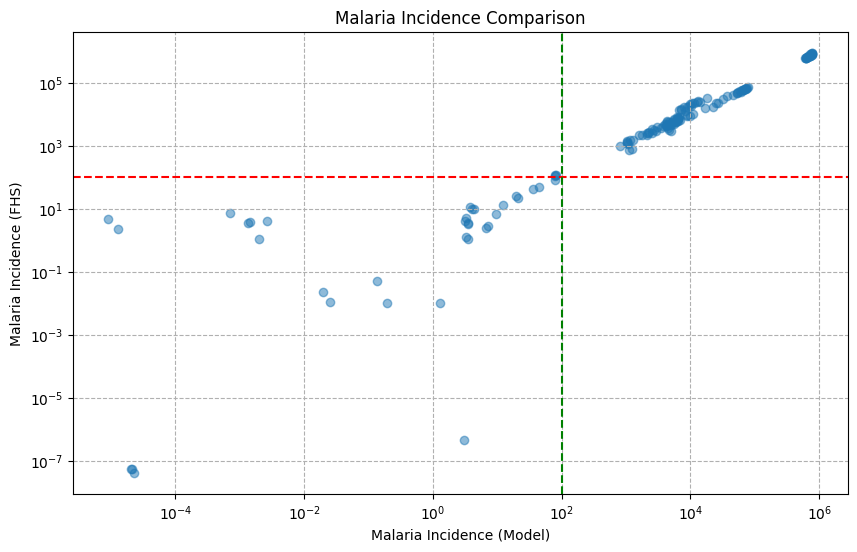

In [19]:
# plot malaria incidence against malaria_incidence_count_fhs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(A0_malaria_df["malaria_mortality"], A0_malaria_df["malaria_mortality_fhs"], alpha=0.5)
plt.xlabel("Malaria Incidence (Model)")
plt.ylabel("Malaria Incidence (FHS)")
plt.title("Malaria Incidence Comparison")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
# Plot lines y=100 and x=100
plt.axhline(y=malaria_mortality_threshold, color='r', linestyle='--', label='FHS Threshold')
plt.axvline(x=malaria_mortality_threshold, color='g', linestyle='--', label='Model Threshold')
plt.show()

In [24]:
A0_malaria_df[(A0_malaria_df["malaria_mortality"] > malaria_mortality_threshold) & (A0_malaria_df["year_id"] == 2022)]

,A0_location_id,year_id,malaria_incidence,malaria_mortality
22,4.0,2022,2.406641e+06,3077.071289
91,103.0,2022,1.523579e+05,1223.391602
114,137.0,2022,3.392541e+06,6300.019043
137,158.0,2022,6.353252e+06,18068.183594
160,166.0,2022,2.291950e+08,652634.312500


In [21]:
A0_malaria_df[(A0_malaria_df["malaria_mortality_fhs"] > malaria_mortality_threshold) & (A0_malaria_df["year_id"] == 2022)]

,A0_location_id,year_id,population,malaria_pfpr,malaria_incidence,malaria_mortality,malaria_incidence_fhs,malaria_mortality_fhs,incidence_raking_factor,mortality_raking_factor
22,4.0,2022,0.0,NaN,2.406641e+06,3077.071289,4.522959e+06,3844.114406,1.879366,1.249277
91,103.0,2022,0.0,NaN,1.523579e+05,1223.391724,9.750603e+05,780.338164,6.399802,0.637848
114,137.0,2022,0.0,NaN,3.392541e+06,6300.019043,5.179483e+06,7490.263701,1.526727,1.188927
137,158.0,2022,0.0,NaN,6.353252e+06,18068.183594,1.233396e+07,32739.280516,1.941362,1.811985
160,166.0,2022,0.0,NaN,2.291950e+08,652634.312500,2.400643e+08,656127.519803,1.047424,1.005352


In [79]:
agg_malaria_fhs_df = agg_malaria_fhs_df[(agg_malaria_fhs_df["malaria_incidence_count_fhs"] > 0) & (agg_malaria_fhs_df["malaria_mortality_count_fhs"] > 0)].copy()
agg_malaria_fhs_df["incidence_raking_factor"] = agg_malaria_fhs_df["malaria_incidence_count_fhs"] / agg_malaria_fhs_df["malaria_incidence"]
agg_malaria_fhs_df["mortality_raking_factor"] = agg_malaria_fhs_df["malaria_mortality_count_fhs"] / agg_malaria_fhs_df["malaria_mortality"]

In [80]:
malaria_df = malaria_df.merge(
    agg_malaria_fhs_df[["fhs_location_id", "year_id", "incidence_raking_factor", "mortality_raking_factor"]],
    on=["fhs_location_id", "year_id"],
    how="left")

In [83]:
malaria_df["malaria_mortality_count_raked"] = malaria_df["malaria_pf_mort_count"] * malaria_df["mortality_raking_factor"]
malaria_df["malaria_incidence_count_raked"] = malaria_df["malaria_pf_inc_count"] * malaria_df["incidence_raking_factor"]
malaria_df["malaria_incidence_rate_raked"] = malaria_df["malaria_incidence_count_raked"] / malaria_df["population"]
malaria_df["malaria_mortality_rate_raked"] = malaria_df["malaria_mortality_count_raked"] / malaria_df["population"]

In [84]:
malaria_df

,location_id,year_id,population,malaria_pfpr,parent_id,level,location_name,path_to_top_parent,A0_location_id,malaria_pf_inc_rate,...,most_detailed_lsae,malaria_mortality_count_fhs,malaria_incidence_count_fhs,fhs_population,incidence_raking_factor,mortality_raking_factor,malaria_mortality_count_raked,malaria_incidence_count_raked,malaria_incidence_rate_raked,malaria_mortality_rate_raked
0,574,2000,98424.976562,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,...,1.0,0.0,0.0,9.958591e+07,NaN,NaN,NaN,NaN,NaN,NaN
1,574,2001,98920.132812,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,...,1.0,0.0,0.0,5.526362e+07,NaN,NaN,NaN,NaN,NaN,NaN
2,574,2002,99334.929688,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,...,1.0,0.0,0.0,9.920396e+07,NaN,NaN,NaN,NaN,NaN,NaN
3,574,2003,99710.710938,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,...,1.0,0.0,0.0,1.072043e+07,NaN,NaN,NaN,NaN,NaN,NaN
4,574,2004,100071.390625,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,...,1.0,0.0,0.0,1.323105e+08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101626,97378,2018,70515.562500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,...,1.0,0.0,0.0,8.011355e+06,NaN,NaN,NaN,NaN,NaN,NaN
1101627,97378,2019,70772.078125,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,...,1.0,0.0,0.0,3.992588e+06,NaN,NaN,NaN,NaN,NaN,NaN
1101628,97378,2020,70946.187500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,...,1.0,0.0,0.0,1.482786e+07,NaN,NaN,NaN,NaN,NaN,NaN
1101629,97378,2021,71013.851562,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,...,1.0,0.0,0.0,1.081542e+07,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:

A0_malaria_df = malaria_df.groupby(
    ["A0_location_id", "year_id"]
).agg(
    malaria_incidence=("malaria_incidence_count_raked", "sum"),
    malaria_mortality=("malaria_mortality_count_raked", "sum")
).reset_index()

In [86]:
A0_malaria_df

,A0_location_id,year_id,malaria_incidence,malaria_mortality
0,4.0,2000,7.588588e+06,13254.202776
1,4.0,2001,7.346943e+06,13454.098996
2,4.0,2002,6.223984e+06,15051.415752
3,4.0,2003,5.807227e+06,16400.981614
4,4.0,2004,6.118268e+06,18442.719998
...,...,...,...,...
156,166.0,2018,2.175804e+08,608180.545344
157,166.0,2019,2.233117e+08,620352.210018
158,166.0,2020,2.360073e+08,691373.453359
159,166.0,2021,2.363225e+08,676889.482141


In [40]:
malaria_df = malaria_df[(malaria_df["malaria_pfpr"] > 0) | (malaria_df["malaria_pf_inc_count"] > 0) | 
                        (malaria_df["malaria_pf_mort_count"] > 0) | (malaria_df["malaria_mortality_count_fhs"] > 0) | 
                        (malaria_df["malaria_incidence_count_fhs"] > 0)]

In [55]:
malaria_df["malaria_mortality_count_fhs"].min()

2.160775846182737e-11

In [ ]:
malaria_2022_df = malaria_df[malaria_df["year_id"] == 2022].copy()
malaria_2022_df = malaria_2022_df[["location_id", "malaria_pfpr", ""]]


,location_id,year_id,population,malaria_pfpr,parent_id,level,location_name,path_to_top_parent,malaria_pf_inc_rate,malaria_pf_inc_count,malaria_pf_mort_rate,malaria_pf_mort_count,fhs_location_id,most_detailed_lsae,Deaths_fhs,Cases_fhs,fhs_population
0,574,2000,98424.976562,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,9.958591e+07
1,574,2001,98920.132812,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,5.526362e+07
2,574,2002,99334.929688,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,9.920396e+07
3,574,2003,99710.710938,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,1.072043e+07
4,574,2004,100071.390625,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,1.323105e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101626,97378,2018,70515.562500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,8.011355e+06
1101627,97378,2019,70772.078125,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,3.992588e+06
1101628,97378,2020,70946.187500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,1.482786e+07
1101629,97378,2021,71013.851562,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,1.081542e+07


In [9]:
malaria_df

,location_id,year_id,population,malaria_pfpr,parent_id,level,location_name,path_to_top_parent,A0_location_id,malaria_pf_inc_rate,malaria_pf_inc_count,malaria_pf_mort_rate,malaria_pf_mort_count,fhs_location_id,most_detailed_lsae,malaria_mortality_count_fhs,malaria_incidence_count_fhs,fhs_population
0,574,2000,98424.976562,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,9.958591e+07
1,574,2001,98920.132812,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,5.526362e+07
2,574,2002,99334.929688,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,9.920396e+07
3,574,2003,99710.710938,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,1.072043e+07
4,574,2004,100071.390625,0.0,523,5,Lauderdale County,"1,64,100,102,523,574",64.0,0.0,0.0,0.0,0.0,523.0,1.0,0.0,0.0,1.323105e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101626,97378,2018,70515.562500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,8.011355e+06
1101627,97378,2019,70772.078125,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,3.992588e+06
1101628,97378,2020,70946.187500,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,1.482786e+07
1101629,97378,2021,71013.851562,0.0,96243,5,Zuidplas,"1,64,73,89,96243,97378",64.0,0.0,0.0,0.0,0.0,89.0,1.0,0.0,0.0,1.081542e+07


In [ ]:
################################################################
#### Get FHS Data for Malaria
################################################################

fhs_data_path = "{FHS_DATA_PATH}/{age_type}_cause_id_{cause_id}_measure_id_{measure_id}_metric_id_{metric_id}_fhs.parquet"

cause = "malaria"
metric = "count"

metric_id = metric_map[metric]["metric_id"]
fhs_population_merged = False
for measure in measure_map:
    measure_id = measure_map[measure]["measure_id"]
    # Grab the all-age FHS data
    fhs_data_path_full = fhs_data_path.format(
        FHS_DATA_PATH=FHS_DATA_PATH,
        age_type=age_type,
        cause_id=cause_map[cause]["cause_id"],
        measure_id=measure_id,
        metric_id=metric_id
    )
    df = read_parquet_with_integer_ids(fhs_data_path_full)
    
    df = df.rename(columns={
        "population": "fhs_population",
        "location_id": "fhs_location_id"
    })

    df = df[["fhs_location_id", "year_id", "val", "fhs_population"]]
    malaria_df = malaria_df.merge(df, on=["fhs_location_id", "year_id"], how="left")
    malaria_df = malaria_df.rename(columns={"val": f"{cause}_{measure}_{metric}_fhs"})

    agg_malaria_fhs_df = agg_malaria_fhs_df.merge(df, on=["fhs_location_id", "year_id"], how="left")
    agg_malaria_fhs_df = agg_malaria_fhs_df.rename(columns={"val": f"{cause}_{measure}_{metric}_fhs"})

# Check if there are any columns that are identical except one ends in _x and the other in _y
if "fhs_population_x" in malaria_df.columns and "fhs_population_y" in malaria_df.columns:
    # If both exist, we need to merge them
    malaria_df = malaria_df.drop(columns=["fhs_population_x"])
    malaria_df = malaria_df.rename(columns={"fhs_population_y": "fhs_population"})

    # Check if there are any columns that are identical except one ends in _x and the other in _y
if "fhs_population_x" in agg_malaria_fhs_df.columns and "fhs_population_y" in agg_malaria_fhs_df.columns:
    # If both exist, we need to merge them
    agg_malaria_fhs_df = agg_malaria_fhs_df.drop(columns=["fhs_population_x"])
    agg_malaria_fhs_df = agg_malaria_fhs_df.rename(columns={"fhs_population_y": "fhs_population"})
